# Initial Modeling Attempts Using Landsat + Modis Features to Predict Coral Presence and Bleaching Using GCBD Data

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

### Loading in Coral Dataset With Modis and Landsat Features

In [328]:
df = pd.read_pickle('./landsat_modis_merged.pkl')
df.head()

,Latitude_Degrees,Longitude_Degrees,Date,Percent_Bleached_Sum_x,geometry_x,coral_presence_x,day,month,year,sur_refl_b08,...,NDVIMNDWI,NDWI,NDWIns,NWI,SWM,WI1,WI2,WRI,datetime_landsat,satellite
0,-18.54628,146.48752,2002-02-15,5.0,POINT (146.48752 -18.54628),1.0,15.0,2.0,2002.0,NaN,...,-0.043600,0.042831,0.473557,-0.458460,1.102316,0.047925,0.056155,1.045674,2002-02-27 00:05:46.058000+00:00,Landsat7
1,-18.44480,146.99328,2002-02-15,37.5,POINT (146.99328 -18.4448),1.0,15.0,2.0,2002.0,NaN,...,-0.141165,0.111533,0.511343,-0.422019,1.231714,0.116840,0.102922,1.155900,2002-02-19 23:59:26.151000+00:00,Landsat7
2,-18.44432,146.99333,2002-02-15,37.5,POINT (146.99333 -18.44432),1.0,15.0,2.0,2002.0,NaN,...,-0.112125,0.109274,0.510101,-0.408188,1.247843,0.098327,0.112007,1.123989,2002-02-19 23:59:26.151000+00:00,Landsat7
3,-23.20148,150.97010,2002-02-15,75.0,POINT (150.9701 -23.20148),1.0,15.0,2.0,2002.0,NaN,...,-0.704783,0.311133,0.621123,-0.125535,2.082294,0.507574,0.507574,2.082294,2002-03-02 23:42:14.385000+00:00,Landsat7
4,24.62700,-81.11000,2004-08-15,17.5,POINT (-81.11 24.627),1.0,15.0,8.0,2004.0,1041.0,...,-0.196979,0.157958,0.536877,-0.360449,1.395649,0.154680,0.167596,1.228442,2004-08-26 15:39:11.911000+00:00,Landsat7


### Testing Models for Coral Presence

In [329]:
coral_presence_cols = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'Blue',
       'Green', 'Red', 'Near Infrared', 'Shortwave Infrared 1',
       'Shortwave Infrared 2', 'QA_PIXEL', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI', 'Date', 'coral_presence_x']
# df = df.replace(-100, 0)
df_presence = df[coral_presence_cols]
df_presence = df_presence.dropna()

In [388]:
df_presence['Date'].min(), df_presence['Date'].max()

(Timestamp('2003-03-13 00:00:00'), Timestamp('2019-08-24 00:00:00'))

In [330]:
from sklearn.model_selection import train_test_split

test_presence = df_presence[df_presence['Date'] > '2016-01-01']
valid_presence = df_presence[(df_presence['Date'] > '2014-01-01') & (df_presence['Date'] < '2016-01-01')]
train_presence = df_presence[df_presence['Date'] < '2014-01-01']

In [331]:
print(f'Train Proportion = {train_presence.shape[0] / df_presence.shape[0]:.2f}')
print(f'Test Proportion = {test_presence.shape[0] / df_presence.shape[0]:.2f}')
print(f'Validation Proportion = {valid_presence.shape[0] / df_presence.shape[0]:.2f}')

Train Proportion = 0.72
Test Proportion = 0.11
Validation Proportion = 0.16


In [332]:
features = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'Blue',
       'Green', 'Red', 'Near Infrared', 'Shortwave Infrared 1',
       'Shortwave Infrared 2', 'QA_PIXEL', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI']
X = train_presence[features]
y = train_presence['coral_presence_x']

In [333]:
X_valid = valid_presence[features]
y_valid = valid_presence['coral_presence_x']

In [340]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=50, reg_alpha=10, reg_lambda=10, max_depth=20, n_estimators=400, learning_rate=0.001)
xgb_model.fit(X, y)

/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[19:08:34] WARNING: /Users/patrickgeitner/xgboost-1.4.2/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=1, num_parallel_tree=1, random_state=50,
              reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [341]:
print(f'Training Accuracy = {xgb_model.score(X, y):.2f}')

Training Accuracy = 0.66


In [342]:
print(f'Validation Accuracy = {xgb_model.score(X_valid, y_valid):.2f}')

Validation Accuracy = 0.57


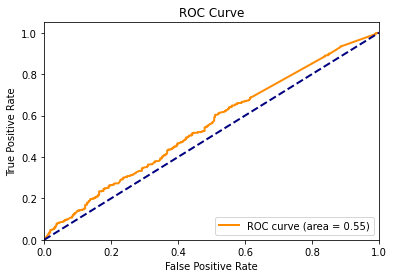

In [343]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_pred = xgb_model.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve') 
plt.legend(loc="lower right")
plt.show()

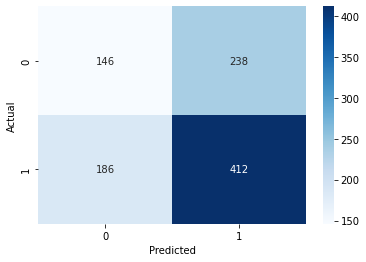

In [344]:
# plotting the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xgb_model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# calculating precision and recall
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
print(f'Validation Precision = {precision:.2f}')
print(f'Validation Recall = {recall:.2f}')

Validation Precision = 0.63
Validation Recall = 0.71


### Testing Models for Coral Bleaching

In [389]:
coral_bleaching_cols = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'Blue',
       'Green', 'Red', 'Near Infrared', 'Shortwave Infrared 1',
       'Shortwave Infrared 2', 'QA_PIXEL', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI', 'Date', 'Percent_Bleached_Sum_x', 'chlor_a', 'sst']
df = df.replace(-100, 0)
df_bleaching = df[coral_bleaching_cols]
df_bleaching = df_bleaching.dropna()

In [390]:
df_bleaching.shape

(1084, 36)

In [391]:
df_bleaching['Date'].min(), df_bleaching['Date'].max()

(Timestamp('2003-05-15 00:00:00'), Timestamp('2018-01-23 00:00:00'))

In [392]:
test_bleaching = df_bleaching[df_bleaching['Date'] > '2016-01-01']
valid_bleaching = df_bleaching[(df_bleaching['Date'] > '2014-01-01') & (df_bleaching['Date'] < '2016-01-01')]
train_bleaching = df_bleaching[df_bleaching['Date'] < '2014-01-01']

In [393]:
features = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'Blue',
       'Green', 'Red', 'Near Infrared', 'Shortwave Infrared 1',
       'Shortwave Infrared 2', 'QA_PIXEL', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI', 'chlor_a', 'sst',]
X = train_bleaching[features]
y = train_bleaching['Percent_Bleached_Sum_x'] / 100

In [394]:
len(features)

34

In [395]:
X_valid = valid_bleaching[features]
y_valid = valid_bleaching['Percent_Bleached_Sum_x'] / 100

In [396]:
from xgboost import XGBRegressor

xgb_bleaching = XGBRegressor(objective="reg:logistic", random_state=42, reg_alpha=4, reg_lambda=4, max_depth=50, n_estimators=400, learning_rate=0.01)
xgb_bleaching.fit(X, y)

/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=50,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=1, num_parallel_tree=1,
             objective='reg:logistic', random_state=42, reg_alpha=4,
             reg_lambda=4, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [397]:
print(f'Model R^2 Score = {xgb_bleaching.score(X_valid, y_valid):.2f}')

Model R^2 Score = 0.14


In [401]:
from sklearn.metrics import mean_absolute_error
print(f'Validation Mean Absolute Error = {mean_absolute_error(y_valid, xgb_bleaching.predict(X_valid)) * 100:.2f}%')

Validation Mean Absolute Error = 14.93%


In [402]:
mean_absolute_error(test_bleaching['Percent_Bleached_Sum_x'] / 100, xgb_bleaching.predict(test_bleaching[features])) * 100

12.77502589317137

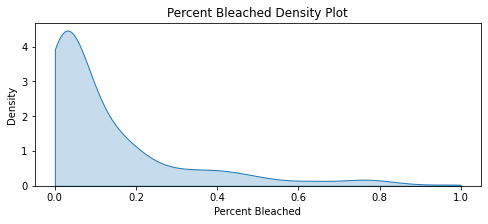

In [403]:
fig, ax = plt.subplots()
# making figure larger
fig.set_size_inches(8, 3)
sns.kdeplot(train_bleaching['Percent_Bleached_Sum_x'] / 100, shade=True, label='Predicted', levels=5, clip=(0.0, 1.0))

plt.xlabel('Percent Bleached')
plt.ylabel('Density')
plt.title('Percent Bleached Density Plot')
plt.show()

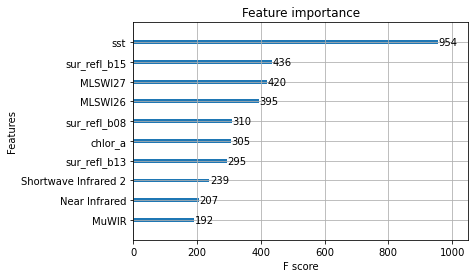

In [447]:
# plotting feature importance
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(xgb_bleaching, max_num_features=10)
plt.show()

### Looking at Ranking Performance of the Bleaching Model

In [407]:
def k_percentile_accuracy(y_true, y_pred, k):
    n = len(y_true)
    k = int(n * k / 100)
    top_k = y_pred.argsort()[:k]
    top_k_actual = y_true.argsort()[:k]
    return len(set(top_k_actual) & set(top_k)) / k

top_k_accs = {}
for k in range(10, 110, 10):
    top_k_accs[k] = k_percentile_accuracy(y_valid, xgb_bleaching.predict(X_valid), k)

# simulating what we could get for  top k accuracy by random chance over 1000 runs
import random
random.seed(42)
random_top_k_accs = {}

for run in range(10000):
    for k in range(10, 110, 10):
        random_top_k_accs[k] = random_top_k_accs.get(k, 0) + k_percentile_accuracy(y_valid, np.random.rand(len(y_valid)), k)

random_top_k_accs = {k: v / 10000 for k, v in random_top_k_accs.items()}

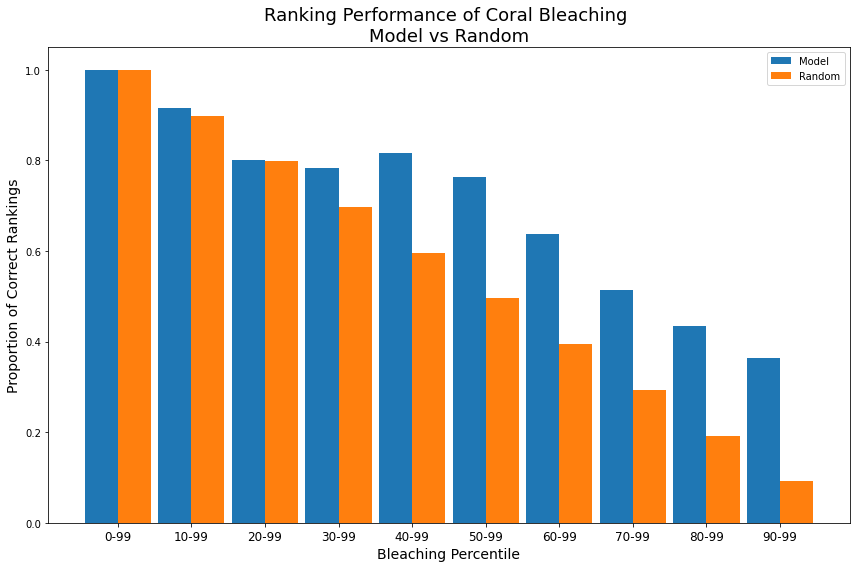

In [408]:
k = [100 - x for x in list(top_k_accs.keys())][::-1]
top_k_accs = list(top_k_accs.values())[::-1]
random_top_k_accs = list(random_top_k_accs.values())[::-1]
x = np.arange(len(k))
width = 0.45

fig, ax = plt.subplots()
# making figure larger
fig.set_size_inches(12, 8)
rects1 = ax.bar(x - width/2, top_k_accs, width, label='Model')
rects2 = ax.bar(x + width/2, random_top_k_accs, width, label='Random')
ax.set_ylabel('Proportion of Correct Rankings', fontsize=14)
ax.set_xlabel('Bleaching Percentile', fontsize=14)
ax.set_title('Ranking Performance of Coral Bleaching \nModel vs Random', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels([f'{val}-99' for  val in k], fontsize=12)
ax.legend()
fig.tight_layout()
plt.show()

### Modeling Coral/Algae Presence with Allen Coral Data

In [430]:
allen_coral = pd.read_pickle('./landsat_modis_allen_spectral_50k.pkl')
allen_coral.columns

Index(['class', 'geometry', 'centroid', 'long', 'lat', 'Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'datetime_landsat', 'datetime_landsat_offset', 'day',
       'month', 'year', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI'],
      dtype='object')

In [432]:
coral_presence_cols = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI', 'class']
# df = df.replace(-100, 0)
allen_coral = allen_coral[coral_presence_cols]
allen_coral = allen_coral.dropna()

In [433]:
features = ['Blue', 'Green', 'Red',
       'Near Infrared', 'Shortwave Infrared 1', 'Shortwave Infrared 2',
       'QA_PIXEL', 'sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10',
       'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14',
       'sur_refl_b15', 'sur_refl_b16', 'AWEInsh', 'AWEIsh', 'LSWI', 'MBWI',
       'MLSWI26', 'MLSWI27', 'MNDWI', 'MuWIR', 'NDVIMNDWI', 'NDWI', 'NDWIns',
       'NWI', 'SWM', 'WI1', 'WI2', 'WRI']
X = allen_coral[features]
y = allen_coral['class']

In [434]:
y.value_counts()

Non-Coral    24501
Coral        21573
Name: class, dtype: int64

In [435]:
# splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# splitting train into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [436]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=50, reg_alpha=10, reg_lambda=10, max_depth=20, n_estimators=400, learning_rate=0.001)
xgb_model.fit(X_train, y_train)

/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/patrickgeitner/miniforge3/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[10:45:37] WARNING: /Users/patrickgeitner/xgboost-1.4.2/build/temp.macosx-11.0-arm64-3.9/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=1, num_parallel_tree=1, random_state=50,
              reg_alpha=10, reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [437]:
xgb_model.score(X_valid, y_valid)

0.9096581660336408

In [438]:
xgb_model.score(X_test, y_test)

0.9112316874660878

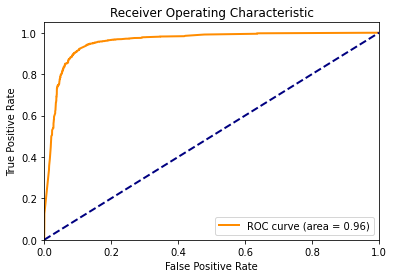

In [448]:
# plotting roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred = xgb_model.predict_proba(X_valid)[:, 1]
fpr, tpr, _ = roc_curve(y_valid, y_pred, pos_label="Non-Coral")
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


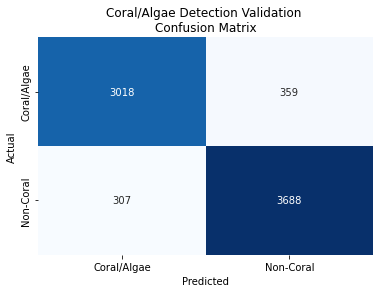

In [451]:
# plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = xgb_model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred, labels=["Coral", "Non-Coral"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Coral/Algae", "Non-Coral"], yticklabels=["Coral/Algae", "Non-Coral"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Coral/Algae Detection Validation \nConfusion Matrix')
plt.show()

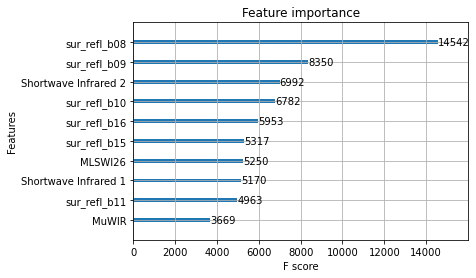

In [446]:
# plotting feature importance
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(xgb_model, max_num_features=10)
plt.show()